In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

In [2]:
import os
import sys
from data import ProcessData
from model import Parser
from LSTM_model import LSTM_Parser
from oracle import *
from decode import *
from conll18_ud_eval import *

In [3]:
# Download the data

# Training
en_training_path = keras.utils.get_file(
    "en_ewt-ud-train.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu")
en_training_txt = open(en_training_path,encoding="utf8")
en_training_data=en_training_txt.read()

en_training_lines = en_training_data.split("\n")

# Validation
en_validation_path = keras.utils.get_file(
    "en_ewt-ud-dev.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu")
en_validation_txt = open(en_validation_path,encoding="utf8")
en_validation_data = en_validation_txt.read()

en_validation_lines = en_validation_data.split("\n")


# Test
en_test_path = keras.utils.get_file(
    "en_ewt-ud-test.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu")
en_test_txt = open(en_test_path,encoding="utf8")
en_test_data = en_test_txt.read()

en_test_lines = en_test_data.split("\n")

In [4]:
# Call the ProcessData class
training_data = ProcessData(en_training_lines)
validation_data=ProcessData(en_validation_lines)
test_data=ProcessData(en_test_lines)

In [5]:
# We create and train the tokenizers for the words and the dependency relations
tokenizer_inputs, _, tokenizer_relations_inputs = training_data.get_tokenizer_inputs()
val_tokenizer_inputs, _, val_tokenizer_relations_inputs = validation_data.get_tokenizer_inputs()

tokenizer = Tokenizer(filters='',lower=False, oov_token='UNK') 
tokenizer.fit_on_texts(tokenizer_inputs + ['EMPTY'])

tokenizer_relations=Tokenizer(filters='',lower=False, oov_token='UNK')
tokenizer_relations.fit_on_texts(tokenizer_relations_inputs + ['None'])

# We create a dictionary with the different actions that the oracle can take.
action_dic = dict()
action_dic['LA']=0
action_dic['RA']=1
action_dic['SHIFT']=2
action_dic['REDUCE']=3

In [6]:
# We prepare the data to train and validate the model 
train_stack, train_buffer,train_transitions, train_relations=training_data.prepare_model_data(tokenizer,action_dic,tokenizer_relations)
val_stack, val_buffer,val_transitions, val_relations=validation_data.prepare_model_data(tokenizer,action_dic,tokenizer_relations)

In [7]:
# We call the class Parser to build, train and validate the neural model
# We also have a LSTM_Parser class that uses LSTM layers instead of Flatten layers, to call it just change the name of the class in the next line to LSTM_Parser
my_parser = Parser(n=2,emb_dim=30, tokenizer=tokenizer, tokenizer_relations=tokenizer_relations)

In [8]:
# We build the model and show the summary of the layers and parameters 
my_parser.build(summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Stack_Input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 Buffer_Input (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 Stack_Embedding (Embedding)    (None, 2, 30)        590310      ['Stack_Input[0][0]']            
                                                                                                  
 Buffer_Embedding (Embedding)   (None, 2, 30)        590310      ['Buffer_Input[0][0]']           
                                                                                              

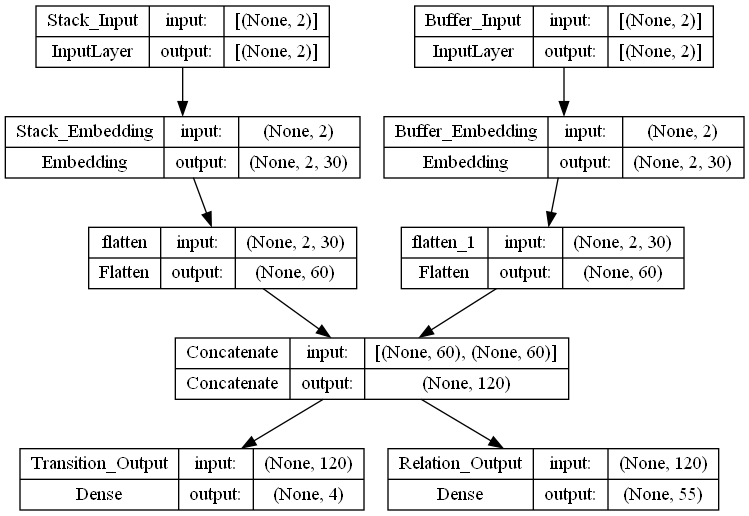

In [9]:
# Show the model architecture and the number of parameters of the model 
my_parser.show()

In [10]:
my_parser.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
my_parser.train(train_stack,train_buffer,train_transitions,train_relations,val_stack,val_buffer,val_transitions,val_relations, epochs=10)

Epoch 1/10
1438/1438 [==============================] - 20s 13ms/step - loss: 2.3251 - Transition_Output_loss: 0.5956 - Relation_Output_loss: 1.7295 - Transition_Output_accuracy: 0.7633 - Relation_Output_accuracy: 0.5946 - val_loss: 1.5155 - val_Transition_Output_loss: 0.4082 - val_Relation_Output_loss: 1.1072 - val_Transition_Output_accuracy: 0.8308 - val_Relation_Output_accuracy: 0.7145
Epoch 2/10
1438/1438 [==============================] - 19s 13ms/step - loss: 1.1011 - Transition_Output_loss: 0.2790 - Relation_Output_loss: 0.8221 - Transition_Output_accuracy: 0.9015 - Relation_Output_accuracy: 0.7926 - val_loss: 1.2871 - val_Transition_Output_loss: 0.3884 - val_Relation_Output_loss: 0.8988 - val_Transition_Output_accuracy: 0.8436 - val_Relation_Output_accuracy: 0.7623
Epoch 3/10
1438/1438 [==============================] - 19s 13ms/step - loss: 0.7580 - Transition_Output_loss: 0.1974 - Relation_Output_loss: 0.5606 - Transition_Output_accuracy: 0.9357 - Relation_Output_accuracy: 0.

In [12]:
# We prepare the data to test the model
test=test_data.create_test_data()
print('Example of the first sentence of the test set:',test[0])

Example of the first sentence of the test set: ['ROOT', 'What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']


In [13]:
# We predict the dependency trees for the test set
predicted_arcs=predict(test,my_parser, tokenizer, action_dic, tokenizer_relations)

In [15]:
predicted_trees=create_trees_from_predicted_arcs(test, predicted_arcs)
save_predicted_arcs(predicted_arcs)
save_trees_conllu(predicted_trees)
save_test_data(en_test_data)

In [ ]:
# Execute the test
gold_path = "gold.conllu"
system_path = "output.conllu"

os.system(f'python conll18_ud-eval.py -v {gold_path} {system_path}')